### ImagesClassificationWithSIFT with zca_whitening_parameter to False and featurewise_std_normalization_parameter to True

In [1]:
## To display the graphs within the code and not in another windows 
import sys
print("Python Version :"+str(sys.version_info))
%matplotlib inline
# To be able to use CSV
import csv
print("CSV Version :"+csv.__version__)
# To be able to use Numpy
import numpy as np
print("Numpy Version :"+np.__version__)
# To be able to use Pandas
import pandas as pd
print("Pandas Version :"+pd.__version__)
# To be able to use Maplotlib
import matplotlib.pyplot as plt

# To be able to use Seaborn
import seaborn as sns
print("Seaborn Version :"+sns.__version__)


# import scipy as sio
# print("Scipy Version :"+sio.__version__)
import scipy.io as sio
import os
import shutil
import random
import cv2 as cv
print("OpenCV Version : "+cv.__version__)
from PIL import Image

# To be able to use Warning
import warnings
import sklearn
print("Sklearn Version : "+sklearn.__version__)
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from catboost import CatBoostClassifier
import catboost
print("Catboost Version : "+catboost.__version__)
from catboost import CatBoostClassifier
# from utils import plot_confusion_matrix

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.xception import preprocess_input
from keras.applications import *
from keras.applications.xception import decode_predictions
from keras.layers import Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import *
import tensorflow as tf
print("Keras Version : "+tf.keras.__version__)
print("Tensorflow Version : "+tf.__version__)

Python Version :sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
CSV Version :1.0
Numpy Version :1.18.5
Pandas Version :1.0.5
Seaborn Version :0.10.1
OpenCV Version : 3.4.2
Sklearn Version : 0.23.1
Catboost Version : 0.24


Using TensorFlow backend.


Keras Version : 2.2.4-tf
Tensorflow Version : 2.1.0


In [2]:
images_directory = './images/Images/'
# train_contents = sio.loadmat('./lists/train_list.mat')
# test_contents = sio.loadmat('./lists/test_list.mat')
# file_list = sio.loadmat('./lists/file_list.mat')
train_directory = './images/train/'
test_directory = './images/test/'

### Rename the folder names

In [ ]:
def convert(word):
    return ''.join(x.capitalize() or '_' for x in word.split('_'))

In [ ]:
for root, dirs, files in os.walk(images_directory):
    for count in dirs:
        print(convert(count.split('-')[1].capitalize()))
        os.rename(os.path.join(images_directory, count), os.path.join(images_directory, convert(count.split('-')[1].capitalize())))


### Creation of the  train test directory

In [ ]:
train_dir = './images/train/'
test_dir = './images/test/'


In [ ]:
files = [file for file in os.listdir(images_directory) if os.path.isfile(os.path.join(images_directory, file))]

In [ ]:
directories = [directory for directory in os.listdir(images_directory)]

In [ ]:
directories

In [ ]:
for directory in directories:
    os.mkdir(train_dir+directory)
    os.mkdir(test_dir+directory)

### Split train test

In [ ]:
directories

In [ ]:
for directory in directories:
    files = [file for file in os.listdir(images_directory+directory) if os.path.isfile(os.path.join(images_directory+directory, file))]
    train_count  = np.round(70/100*len(files))
    test_count = np.round(30/100*len(files))
    rndnums = list(random.sample(range(0, len(files)), len(files)))
    print("len(files)",len(files))
    train_file_index = rndnums[0:int(train_count)+1]
    train_file_name = [files[i] for i in train_file_index]
    test_file_index = rndnums[int(train_count)+1:int(train_count + test_count)+1]
    test_file_name = [files[i] for i in test_file_index]
    for x in train_file_name:
        file = x
        shutil.copyfile(os.path.join(images_directory+directory, file), os.path.join(train_directory+directory, file))
    ##test_files
    for y in test_file_name:
        file = y
        shutil.copyfile(os.path.join(images_directory+directory, file), os.path.join(test_directory+directory, file))

    

In [5]:
input_directory='./images/'
output_directory='./new_images/'
small_directory_names = [directory for directory in os.listdir(input_directory+'train-small')]
small_directory_names.sort()
zca_whitening_parameter=False
featurewise_std_normalization_parameter=True
color_mode_parameter='grayscale'
save_prefix_parameter='set1_'
batch_size=2
follow_links=True
train_datagen1 = ImageDataGenerator(
        rescale=1./255,
        zca_whitening=zca_whitening_parameter,
        featurewise_std_normalization=featurewise_std_normalization_parameter
        )
train_datagen2 = ImageDataGenerator(
        rescale=1./255,
        )

In [6]:
small_directory_names

['Basset', 'Cardigan', 'OldEnglishSheepdog']

In [7]:
myCategories = dict(enumerate(small_directory_names))

In [8]:
myCategories

{0: 'Basset', 1: 'Cardigan', 2: 'OldEnglishSheepdog'}

In [9]:
class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.2, subset=None):
        """Constructor for mixup image data generator.
        Arguments:
            generator {object} -- An instance of Keras ImageDataGenerator.
            directory {str} -- Image directory.
            batch_size {int} -- Batch size.
            img_height {int} -- Image height in pixels.
            img_width {int} -- Image width in pixels.
        Keyword Arguments:
            alpha {float} -- Mixup beta distribution alpha parameter. (default: {0.2})
            subset {str} -- 'training' or 'validation' if validation_split is specified in
            `generator` (ImageDataGenerator).(default: {None})
        """

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        # First iterator yielding tuples of (x, y)
        self.generator1 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Second iterator yielding tuples of (x, y)
        self.generator2 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Number of images across all classes in image directory.
        self.n = self.generator1.samples

    def reset_index(self):
        """Reset the generator indexes array.
        """

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        """Get number of steps per epoch based on batch size and
        number of images.
        Returns:
            int -- steps per epoch.
        """

        return self.n // self.batch_size

    def __next__(self):
        """Get next batch input/output pair.
        Returns:
            tuple -- batch of input/output pair, (inputs, outputs).
        """

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

        # random sample the lambda value from beta distribution.
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)

        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y

    def __iter__(self):
        while True:
            yield next(self)

In [10]:
train_generator1 = train_datagen1.flow_from_directory(input_directory+'train-small', target_size=(224, 224), follow_links=True, batch_size=batch_size, class_mode='categorical', save_format='jpeg', classes=small_directory_names, subset='training', shuffle=False, color_mode=color_mode_parameter)

Found 350 images belonging to 3 classes.


In [11]:
train_generator2 = train_datagen2.flow_from_directory(input_directory+'train-small', target_size=(224, 224), follow_links=True, batch_size=batch_size, class_mode='categorical', save_format='jpeg', classes=small_directory_names, subset='training', shuffle=False, color_mode=color_mode_parameter)

Found 350 images belonging to 3 classes.


In [12]:
test_generator = train_datagen2.flow_from_directory(input_directory+'test-small', target_size=(224, 224), follow_links=True, batch_size=batch_size, class_mode='categorical', save_format='jpeg', classes=small_directory_names, shuffle=False, color_mode=color_mode_parameter)

Found 148 images belonging to 3 classes.


In [13]:
train_df = pd.DataFrame(columns=["Category", "Picture","Descriptors", "NumberOfDescriptors"])

In [14]:
test_df = pd.DataFrame(columns=["Category", "Picture","Descriptors", "NumberOfDescriptors"])

### Compute the descriptors  and add them with the category into a dataframe

In [15]:
algo_constructor = cv.xfeatures2d.SIFT_create()
l = np.random.beta(0.2, 0.2, batch_size)
X_l = l.reshape(batch_size, 1, 1, 1)
y_l = l.reshape(batch_size, 1)
def computeDescriptorsforTwoGenerators(mygenerator1,mygenerator2, mydf, mydescriptors):
    count = 0
    for i in range(train_generator1.n):
        X1, y1 = train_generator1.next()
        X2, y2 = train_generator2.next()
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        for j in range(batch_size):
            imgwithrgb = cv.merge([X[j], X[j], X[j]])
            image8bit = cv.normalize(imgwithrgb, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
            keypoints, descriptors = algo_constructor.detectAndCompute(image8bit, None)
            mydf = mydf.append({'Category': y[j].tolist().index(1), 'Picture':image8bit, 'Descriptors':descriptors, 'NumberOfDescriptors':descriptors.shape[0]}, ignore_index='True')
            mydescriptors.extend(descriptors)
            j = j+1
        i = i + 1
    mydf['Category'] = mydf['Category'].map(myCategories) 
    return mydf, mydescriptors

In [16]:
algo_constructor = cv.xfeatures2d.SIFT_create()
def computeDescriptors(mygenerator, mydf, mydescriptors):
    count = 0
    for i in range(len(mygenerator)):
    #next(train_generator)
        for j in range(batch_size):
            img = mygenerator[i][0][j].squeeze()
            imgwithrgb = cv.merge([img, img, img])
            image8bit = cv.normalize(imgwithrgb, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
            keypoints, descriptors = algo_constructor.detectAndCompute(image8bit, None)
            mydf = mydf.append({'Category': mygenerator[i][1][j].tolist().index(1), 'Picture':image8bit, 'Descriptors':descriptors, 'NumberOfDescriptors':descriptors.shape[0]}, ignore_index='True')
            mydescriptors.extend(descriptors)
            count = count + 1
            j = j+1
        i = i+1
    mydf['Category'] = mydf['Category'].map(myCategories) 
    return mydf, mydescriptors

### Train 

In [18]:
train_descriptors_array=[]
train_df, train_descriptors_array=computeDescriptorsforTwoGenerators(train_generator1, train_generator2, train_df, train_descriptors_array)

/home/david/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/david/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


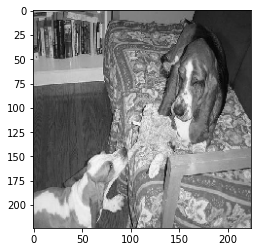

In [19]:
plt.imshow(train_df['Picture'][0])
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(60, 12))
axs[0].set_title('An Original Picture in grayscale  ', fontsize=20)
axs[0].imshow(train_df['Picture'][0], cmap='Greys_r')
axs[1].set_title('Histogram of an original Picture in grayscale ', fontsize=20)
axs[1].set_xlabel('Level of gray', fontsize=20)
axs[1].set_ylabel('Number of pixels', fontsize=20)
axs[1].hist(train_df['Picture'][0].ravel(), 256, [0, 256])


### Test

In [20]:
test_descriptors_array=[]
test_df, test_descriptors_array=computeDescriptors(test_generator, test_df, test_descriptors_array)

In [21]:
print(train_df['NumberOfDescriptors'].sum())

226736


In [22]:
print(test_df['NumberOfDescriptors'].sum())

46444


### Apply a Kmeans to get clusters

In [23]:
# A k-means clustering algorithm who takes 2 parameter which is number
# of cluster(k) and the other is descriptors list(unordered 1d array)
# Returns an array that holds central points.
def kmeans(k, descriptor_list):
    # kmeans = KMeans(n_clusters=k, n_init=10)
    mymodel = MiniBatchKMeans(n_clusters=k, n_init=10)
    mymodel.fit(descriptor_list)
    visual_words = mymodel.cluster_centers_
    labels = mymodel.labels_
    silhouette_score = metrics.silhouette_score(descriptor_list, labels)
    calinski_harabasz_score = metrics.calinski_harabasz_score(descriptor_list, labels)
    print('silhouette_score '+str(silhouette_score))
    print('calinski_harabasz_score '+str(calinski_harabasz_score))
    return mymodel, visual_words, labels
# Takes the central points which is visual words
model, visual_words, labels = kmeans(150, train_descriptors_array)

silhouette_score 0.026418861
calinski_harabasz_score 1125.6096278606612


In [24]:
X_train = pd.DataFrame(columns=range(len(visual_words)))
X_test = pd.DataFrame(columns=range(len(visual_words)))

In [25]:
for index, row in train_df.iterrows():
    labels = model.predict(pd.DataFrame(row["Descriptors"]).astype(float))
    unique, counts = np.unique(labels, return_counts=True)
    X_train = X_train.append(dict(zip(unique, counts)), ignore_index=True)

In [26]:
X_train.fillna(0, inplace=True)

In [ ]:
X_train

In [ ]:
train_df

### TSNE

In [27]:
X_train_embedded = TSNE(n_components=2).fit_transform(X_train)
X_train_embedded_df = pd.DataFrame(X_train_embedded, columns=['SIFT1', 'SIFT2'])

In [28]:
X_train_embedded_df['Category'] = train_df['Category']

silhouette_score -0.020029584
calinski_harabasz_score 7.324503443115568


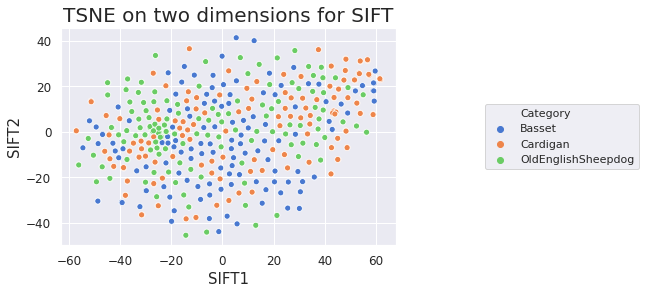

In [29]:
sns.set(palette='muted', color_codes=True, style='darkgrid')
ax = sns.scatterplot(x='SIFT1', y='SIFT2', hue="Category", data=X_train_embedded_df)
ax.set_title('TSNE on two dimensions for SIFT', fontsize=20)
ax.set_xlabel('SIFT1', fontsize=15)
ax.set_ylabel('SIFT2', fontsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
ax.tick_params(labelsize=12)
silhouette_score = metrics.silhouette_score(X_train_embedded, train_df['Category'])
calinski_harabasz_score = metrics.calinski_harabasz_score(X_train_embedded, train_df['Category'])
print('silhouette_score '+str(silhouette_score))
print('calinski_harabasz_score '+str(calinski_harabasz_score))

In [30]:
for index, row in test_df.iterrows():
    labels = model.predict(pd.DataFrame(row["Descriptors"]).astype(float))
    unique, counts = np.unique(labels, return_counts=True)
    X_test = X_test.append(dict(zip(unique, counts)), ignore_index=True)

In [31]:
X_test.fillna(0, inplace=True)

In [ ]:
X_test

In [32]:
le = LabelEncoder().fit(train_df['Category'])

In [33]:
y_train = le.transform(train_df['Category'])
y_test = le.transform(test_df['Category'])

In [34]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### CatBoostClassifier 

In [35]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)

In [36]:
clf.fit(
    X_train, y_train
    # cat_features=[0, 1, 2]
)

0:	learn: 1.0781149	total: 58.8ms	remaining: 58.7s
1:	learn: 1.0513558	total: 61.9ms	remaining: 30.9s
2:	learn: 1.0249196	total: 65ms	remaining: 21.6s
3:	learn: 1.0064123	total: 67.5ms	remaining: 16.8s
4:	learn: 0.9902279	total: 71.6ms	remaining: 14.3s
5:	learn: 0.9725558	total: 74.9ms	remaining: 12.4s
6:	learn: 0.9547746	total: 78.4ms	remaining: 11.1s
7:	learn: 0.9372440	total: 81.4ms	remaining: 10.1s
8:	learn: 0.9156520	total: 84.3ms	remaining: 9.29s
9:	learn: 0.8927617	total: 87.7ms	remaining: 8.68s
10:	learn: 0.8774925	total: 90.8ms	remaining: 8.16s
11:	learn: 0.8622045	total: 93.8ms	remaining: 7.72s
12:	learn: 0.8517768	total: 97ms	remaining: 7.36s
13:	learn: 0.8404813	total: 100ms	remaining: 7.05s
14:	learn: 0.8249817	total: 103ms	remaining: 6.78s
15:	learn: 0.8110677	total: 107ms	remaining: 6.57s
16:	learn: 0.7995412	total: 110ms	remaining: 6.38s
17:	learn: 0.7831764	total: 114ms	remaining: 6.21s
18:	learn: 0.7677153	total: 119ms	remaining: 6.14s
19:	learn: 0.7554536	total: 122m

168:	learn: 0.1112152	total: 1.04s	remaining: 5.14s
169:	learn: 0.1101233	total: 1.05s	remaining: 5.14s
170:	learn: 0.1091547	total: 1.06s	remaining: 5.13s
171:	learn: 0.1079344	total: 1.06s	remaining: 5.13s
172:	learn: 0.1070451	total: 1.07s	remaining: 5.13s
173:	learn: 0.1061312	total: 1.08s	remaining: 5.12s
174:	learn: 0.1050799	total: 1.08s	remaining: 5.11s
175:	learn: 0.1045913	total: 1.09s	remaining: 5.1s
176:	learn: 0.1038953	total: 1.1s	remaining: 5.1s
177:	learn: 0.1030312	total: 1.1s	remaining: 5.09s
178:	learn: 0.1018706	total: 1.11s	remaining: 5.08s
179:	learn: 0.1010117	total: 1.11s	remaining: 5.06s
180:	learn: 0.1001087	total: 1.11s	remaining: 5.04s
181:	learn: 0.0991253	total: 1.12s	remaining: 5.05s
182:	learn: 0.0981407	total: 1.13s	remaining: 5.06s
183:	learn: 0.0974100	total: 1.15s	remaining: 5.11s
184:	learn: 0.0965672	total: 1.17s	remaining: 5.14s
185:	learn: 0.0954635	total: 1.17s	remaining: 5.13s
186:	learn: 0.0947335	total: 1.18s	remaining: 5.12s
187:	learn: 0.09

330:	learn: 0.0379516	total: 2.67s	remaining: 5.4s
331:	learn: 0.0377903	total: 2.68s	remaining: 5.39s
332:	learn: 0.0376687	total: 2.69s	remaining: 5.38s
333:	learn: 0.0374603	total: 2.7s	remaining: 5.38s
334:	learn: 0.0373142	total: 2.71s	remaining: 5.38s
335:	learn: 0.0371556	total: 2.72s	remaining: 5.38s
336:	learn: 0.0369822	total: 2.73s	remaining: 5.38s
337:	learn: 0.0368203	total: 2.74s	remaining: 5.37s
338:	learn: 0.0366300	total: 2.75s	remaining: 5.36s
339:	learn: 0.0364553	total: 2.76s	remaining: 5.35s
340:	learn: 0.0363173	total: 2.76s	remaining: 5.34s
341:	learn: 0.0362218	total: 2.77s	remaining: 5.33s
342:	learn: 0.0360367	total: 2.78s	remaining: 5.32s
343:	learn: 0.0358457	total: 2.79s	remaining: 5.32s
344:	learn: 0.0356631	total: 2.79s	remaining: 5.31s
345:	learn: 0.0355346	total: 2.81s	remaining: 5.31s
346:	learn: 0.0353322	total: 2.83s	remaining: 5.33s
347:	learn: 0.0351561	total: 2.86s	remaining: 5.37s
348:	learn: 0.0350124	total: 2.88s	remaining: 5.36s
349:	learn: 0.

496:	learn: 0.0203685	total: 4.93s	remaining: 4.99s
497:	learn: 0.0203058	total: 4.95s	remaining: 4.99s
498:	learn: 0.0202428	total: 4.96s	remaining: 4.98s
499:	learn: 0.0201724	total: 4.97s	remaining: 4.97s
500:	learn: 0.0201005	total: 4.98s	remaining: 4.96s
501:	learn: 0.0200523	total: 4.99s	remaining: 4.95s
502:	learn: 0.0199720	total: 5s	remaining: 4.95s
503:	learn: 0.0198930	total: 5.01s	remaining: 4.93s
504:	learn: 0.0198305	total: 5.02s	remaining: 4.92s
505:	learn: 0.0197848	total: 5.03s	remaining: 4.91s
506:	learn: 0.0197338	total: 5.04s	remaining: 4.9s
507:	learn: 0.0196836	total: 5.05s	remaining: 4.89s
508:	learn: 0.0195916	total: 5.05s	remaining: 4.88s
509:	learn: 0.0195295	total: 5.1s	remaining: 4.9s
510:	learn: 0.0194690	total: 5.12s	remaining: 4.9s
511:	learn: 0.0194264	total: 5.13s	remaining: 4.89s
512:	learn: 0.0193700	total: 5.15s	remaining: 4.89s
513:	learn: 0.0193219	total: 5.17s	remaining: 4.89s
514:	learn: 0.0192881	total: 5.2s	remaining: 4.89s
515:	learn: 0.019252

664:	learn: 0.0132987	total: 7.25s	remaining: 3.65s
665:	learn: 0.0132615	total: 7.26s	remaining: 3.64s
666:	learn: 0.0132293	total: 7.26s	remaining: 3.63s
667:	learn: 0.0131934	total: 7.27s	remaining: 3.62s
668:	learn: 0.0131663	total: 7.28s	remaining: 3.6s
669:	learn: 0.0131278	total: 7.35s	remaining: 3.62s
670:	learn: 0.0130948	total: 7.42s	remaining: 3.64s
671:	learn: 0.0130696	total: 7.48s	remaining: 3.65s
672:	learn: 0.0130372	total: 7.52s	remaining: 3.66s
673:	learn: 0.0130101	total: 7.59s	remaining: 3.67s
674:	learn: 0.0129814	total: 7.64s	remaining: 3.68s
675:	learn: 0.0129446	total: 7.67s	remaining: 3.68s
676:	learn: 0.0129225	total: 7.68s	remaining: 3.67s
677:	learn: 0.0129027	total: 7.71s	remaining: 3.66s
678:	learn: 0.0128669	total: 7.72s	remaining: 3.65s
679:	learn: 0.0128361	total: 7.73s	remaining: 3.64s
680:	learn: 0.0128054	total: 7.74s	remaining: 3.63s
681:	learn: 0.0127826	total: 7.75s	remaining: 3.61s
682:	learn: 0.0127652	total: 7.76s	remaining: 3.6s
683:	learn: 0.

826:	learn: 0.0097254	total: 9.72s	remaining: 2.03s
827:	learn: 0.0097083	total: 9.73s	remaining: 2.02s
828:	learn: 0.0096916	total: 9.74s	remaining: 2.01s
829:	learn: 0.0096735	total: 9.75s	remaining: 2s
830:	learn: 0.0096600	total: 9.76s	remaining: 1.98s
831:	learn: 0.0096465	total: 9.8s	remaining: 1.98s
832:	learn: 0.0096313	total: 9.86s	remaining: 1.98s
833:	learn: 0.0096180	total: 9.87s	remaining: 1.97s
834:	learn: 0.0096034	total: 9.89s	remaining: 1.95s
835:	learn: 0.0095846	total: 9.91s	remaining: 1.94s
836:	learn: 0.0095628	total: 9.91s	remaining: 1.93s
837:	learn: 0.0095482	total: 9.92s	remaining: 1.92s
838:	learn: 0.0095366	total: 9.93s	remaining: 1.91s
839:	learn: 0.0095149	total: 9.94s	remaining: 1.89s
840:	learn: 0.0094987	total: 9.94s	remaining: 1.88s
841:	learn: 0.0094852	total: 9.95s	remaining: 1.87s
842:	learn: 0.0094696	total: 9.99s	remaining: 1.86s
843:	learn: 0.0094513	total: 10s	remaining: 1.85s
844:	learn: 0.0094354	total: 10.1s	remaining: 1.84s
845:	learn: 0.0094

989:	learn: 0.0075944	total: 12.4s	remaining: 126ms
990:	learn: 0.0075837	total: 12.4s	remaining: 113ms
991:	learn: 0.0075770	total: 12.5s	remaining: 101ms
992:	learn: 0.0075675	total: 12.5s	remaining: 88ms
993:	learn: 0.0075601	total: 12.5s	remaining: 75.5ms
994:	learn: 0.0075485	total: 12.5s	remaining: 62.9ms
995:	learn: 0.0075378	total: 12.5s	remaining: 50.3ms
996:	learn: 0.0075254	total: 12.5s	remaining: 37.7ms
997:	learn: 0.0075163	total: 12.5s	remaining: 25.1ms
998:	learn: 0.0075051	total: 12.6s	remaining: 12.6ms
999:	learn: 0.0074946	total: 12.6s	remaining: 0us


In [37]:
y_pred = clf.predict(data=X_test)

In [38]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,7.0,0.0,3.0,10.0,0.0,0.0,6.0,2.0,3.0,2.0,...,2.0,4.0,1.0,1.0,2.0,3.0,2.0,1.0,4.0,7.0
1,1.0,1.0,3.0,0.0,4.0,1.0,1.0,2.0,0.0,2.0,...,5.0,4.0,1.0,6.0,1.0,1.0,2.0,1.0,7.0,7.0
2,6.0,3.0,3.0,7.0,0.0,2.0,7.0,2.0,0.0,3.0,...,2.0,1.0,3.0,0.0,4.0,0.0,0.0,1.0,4.0,1.0
3,4.0,0.0,0.0,7.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,6.0,1.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,2.0,4.0,2.0,1.0,1.0,0.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,0.0,1.0,1.0,2.0,1.0,1.0,3.0,4.0,0.0,1.0,...,1.0,0.0,0.0,1.0,5.0,0.0,1.0,1.0,0.0,0.0
144,12.0,1.0,1.0,6.0,4.0,7.0,0.0,1.0,1.0,2.0,...,1.0,0.0,3.0,1.0,0.0,0.0,1.0,6.0,3.0,3.0
145,0.0,1.0,2.0,1.0,3.0,0.0,5.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,4.0,0.0,1.0,2.0,0.0,0.0
146,2.0,1.0,2.0,3.0,4.0,4.0,0.0,3.0,2.0,4.0,...,3.0,3.0,2.0,1.0,6.0,2.0,0.0,2.0,3.0,2.0


### Results

----- Accuracy: 54.05 % -----


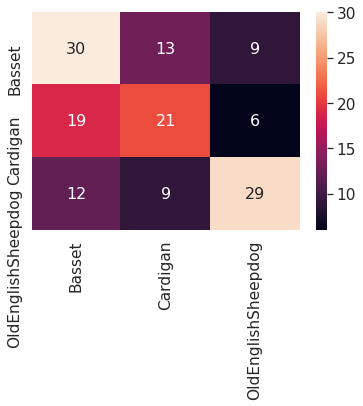

In [39]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), small_directory_names, small_directory_names)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()